In [1]:
#
#    Statistical and charting code used to produce
#    'Do rapid review methods for study identification affect meta-analysis results?—a simulation study'
#    Iain Marshall (mail@ijmarshall.com)
#

In [2]:
# imports

import json
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import math
from collections import defaultdict, Counter, OrderedDict
import tqdm
import pandas as pd
import yaml

In [3]:
# load data

with open('../data2/meta_analyses2.json', 'r') as f:
    data = json.load(f)

In [4]:
# descriptive statistics

total_ma = len(data)

print("Number of meta-analyses:", total_ma)

median_studies_ma = np.percentile([len(r['study_data']) for r in data], [50, 25, 75])
print("Median studies per meta-analysis (IQR): {} ({}–{})".format(*median_studies_ma))

# median study size
study_sizes = [(int(study['int_total']) + int(study['cnt_total'])) for sublist in data for study in sublist['study_data']]
total_studies = len(study_sizes)
print("Total number of studies:", total_studies)

print("Median sample size per study (IQR): {} ({}–{})".format(*np.percentile(study_sizes, [50, 25, 75])))

# median sample per MA
study_sizes = [sum([(int(study['int_total']) + int(study['cnt_total'])) for study in row['study_data']]) for row in data]
print("Median sample size per MA (IQR): {} ({}–{})".format(*np.percentile(study_sizes, [50, 25, 75])))

print("Number of analyses with a control/care as usual arm: {}".format(len([r for r in data if r['favours_control_arm'] in [0, 1, 2]])))

Number of meta-analyses: 2512
Median studies per meta-analysis (IQR): 4.0 (2.0–7.0)
Total number of studies: 16088
Median sample size per study (IQR): 101.0 (52.0–250.0)
Median sample size per MA (IQR): 549.5 (171.0–1662.5)
Number of analyses with a control/care as usual arm: 2512


In [6]:
# load/setup the 'meta' package in R
meta = importr('meta')
meta.settings_meta("revman5")


** RevMan 5 settings already in used (R package meta). **




R object with classes: ('list',) mapped to:
<ListVector - Python:0x7ff0c6e83e08 / R:0x559910f89180>
[FloatVector, FloatVector, BoolVector, BoolVector, ..., BoolVector, BoolVector, BoolVector, FloatVector]
  level: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7ff0c6e83348 / R:0x55990e884918>
[0.950000]
  level.comb: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7ff0c6e83048 / R:0x55990e8848b8>
[0.950000]
  comb.fixed: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7ff0c6e83408 / R:0x55990e884858>
[       1]
  comb.random: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7ff0c6e83bc8 / R:0x55990e884828>
[       1]
...
  method.tau: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7ff0c6e830c8 / R:0x559910537ff8>
[       1]
  tau.common: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7ff0c6e83e48 / R:0x55991053dd28>
[       1]
  prediction: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7ff0c6e83d88 / R:0x559910544218>
[       1]
  level.predict: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7ff0c6e83cc8 / R:0x55990e886c98>
[2.000000]

In [7]:
# functions for calling 'meta' via R

def do_meta(study_data, units, method, swap_events):
    m = lambda x: robjects.IntVector([int(r[x]) for r in study_data])
    event_e = m('int_events')
    n_e = m('int_total')
    event_c = m('cnt_events')
    n_c = m('cnt_total')
    
    if swap_events:
        event_e = n_e.ro - event_e
        event_c = n_c.ro - event_c
        
    return meta.metabin(event_e, n_e, event_c, n_c, sm=units, RR_cochrane=True, method=method)



def get_stats_from_r(meta_out, units, random_str):
    m = lambda x: meta_out.rx("{}.{}".format(x, random_str))[0][0]
    em = lambda x: math.exp(m(x))    
    num_studies = len(meta_out.rx('n.e')[0])
    i2 = meta_out.rx('I2')[0][0]
    return {'point': em('TE'), 'lower': em('lower'), 'upper': em('upper'), 'num_studies': num_studies, 'I2': i2}
    

In [46]:
# functions for classifying changes in meta-analyses


def quant_sig(res1, res2):
    
    # work out change in significance
    # res1 = sr result, res2 = sim rr result
    
    def _sig(r):
        if r['lower'] > 1.0:
            return 1 # significant increase
        elif r['upper'] < 1.0:
            return -1 # significant reduction
        else:
            return 0
    
    s1 = _sig(res1)
    s2 = _sig(res2)
    
    if s1 == s2:
        return 'No change in significance'
    elif s1 != 0 and s2 == 0:
        return 'Significant to non-significant'
    elif s1 * s2 == -1:
        return 'Change in effect direction'
    elif s1 == 0 and s2 != 0:
        return 'Non-significant to significant'
    else:
        raise('Unhandled significance s1={} s2={}'.format(s1, s2))


def sig_text(r):
    if r['lower'] > 1.0:
        return "Significant" # significant increase
    elif r['upper'] < 1.0:
        return "Significant" # significant reduction
    else:
        return "Non significant"
    
    
def quant_change(res1, res2):
    # return effect size changes
    
    # if nan's then the sensitivity analysis is not calculable (i.e. no events)
    # this shouldn't happen since zero events would not be sent here
    # 'Not calculable' in the results therefore would indicate a bug
    if math.isnan(res2['point']):
        return "Not calculable"
    
    if all([res1[k]==res2[k] for k in ['point', 'lower', 'upper']]):
        return 'No important change' # results identical

    # if results not identical work out size of difference in log OR
    logpoint1 = math.log(res1['point'])
    logpoint2 = math.log(res2['point'])
    logdiff = abs(logpoint2-logpoint1)
    
    #     sd_effect_size_cdsr = 0.3591098412 from original calculations
    #     cohen's 0.2, 0.5, and 0.8 SD cutoffs
    #     rounded/aligned to other studies, making 5%, 20%, and 30%
      
    if logdiff < math.log(1.05):
        return 'No important change'
    elif logdiff < math.log(1.20):
        return 'Small'
    elif logdiff < math.log(1.30):
        return 'Moderate'
    else:
        return 'Large'

def bias_analysis(baseline, sim, favours_control_arm, swap_events=False):
    """
    presents re-oriented log change data, so that a reduction is always int=better
    and increase is always intervention=better
    Returns a -ve result if rapid reviews favour the intervention
    Returns a +ve result if rapid reviews favour the control
    Returns 0 if no difference
    """
    
    if swap_events==True:
        # swapped events also need favours labels
        favours_control_arm = 2 if favours_control_arm == 1 else 1
    
    log_baseline = math.log(baseline['point'])
    log_sim = math.log(sim['point'])
        
    if favours_control_arm == 2:
        # i.e. the way around we want (2 = the right side of the axis)
        # return log ROR, so that negative numbers = favours intervention
        return log_sim - log_baseline
    
    if favours_control_arm == 1:
        # i.e. the way around we want (2 = the right side of the axis)
        # return log ROR, so that negative numbers = favours intervention
        return log_baseline - log_sim
        
        
    
    

In [47]:
# EXAMPLE (mostly to illustrate/confirm the direction of effect)

# Let's say, an original meta-analysis finds an OR of 0.8 (i.e. in favour of intervention)
# The rapid simulation finds an OR of 0.6 (i.e. even *more* in favour of intervention)
# We therefore want the log ROR to be -ve

# log_baseline = log(0.8) = -0.0969
# log _sim = log(0.6) =-0.2218

# favours_control_arm = 2 (since ORs >1 will favour control)

# log_ROR    = log_sim - log_baseline
#            = -0.2218 - (-0.0969)
#            = -0.1249

# abs_ROR    = exp(-0.1249) = 0.882

# percentage change = (abs_ROR - 1) * 100 = -11.8%
# the percentage change is negative, since the rapid review favours intervention

In [48]:
# the simulation codes in the data
sim_codes = ["in_pubmed_prim",  "in_pubmed_any", "search_max_5yr", "search_max_7yr", "search_max_10yr", "search_max_15yr", "search_max_20yr", "sample_min_50", "sample_min_100", "sample_min_200", "largest_trial"]
sim_titles = ['Citation in PubMed (primary reference)', 'Citation in PubMed (any reference)', 'Search 5 years', 'Search 7 years', 'Search 10 years', 'Search 15 years', 'Search 20 years', 'Exclude <50 people', 'Exclude <100 people', 'Exclude <200 people', 'Largest trial only']

# the bias domains to assess
domains = ['Random sequence generation', 'Allocation concealment', 'Blinding of participants and personnel', 'Blinding of outcome assessment']

# change category ordering
sig_change_cats = ['No change in significance', 'Significant to non-significant', 'Non-significant to significant',  'Change in effect direction', 'All events lost', 'All studies lost']
effect_change_cats = ['No important change', 'Small', 'Moderate', 'Large', 'All events lost', 'All studies lost']

In [49]:
# run the meta-analyses
sig_results = defaultdict(Counter)
effect_results = defaultdict(Counter)
log_effect_sizes = defaultdict(list)
# NB this applies only to calculable meta-analyses (i.e. not those which have compelete data loss)

# sig_flow = defaultdict(list)

char_includes = {s: {"included": [], "total": []} for s in sim_codes}
char_bias = {s: {d: {"included": [], "excluded": []} for d in domains} for s in sim_codes}
char_sample_size = {s: {"included": [], "excluded": []} for s in sim_codes}


for ma in tqdm.tqdm(data):
    
    baseline_r = do_meta(ma['study_data'], 'OR', ma['method'], ma['swap_events'])
    baseline = get_stats_from_r(baseline_r, 'OR', ma['random'])
    
    for sim_method in sim_codes:
        
        included_data = [s for s in ma['study_data'] if s[sim_method]]
        excluded_data = [s for s in ma['study_data'] if not s[sim_method]]
        
        # raw numbers
        char_includes[sim_method]["included"].append(len(included_data))
        char_includes[sim_method]["total"].append(len(ma['study_data']))
        
        if len(included_data)==0:
            # no studies left
            # (and therefore not possibile to calculate change in effect size)
            sig_results[sim_method]['All studies lost'] += 1
            effect_results[sim_method]['All studies lost'] += 1
            
        elif sum([(int(r['int_events']) + int(r['cnt_events'])) for r in included_data])==0:
            # studies left, but have 0 events in them
            # (and also not possibile to calculate change in effect size)
            sig_results[sim_method]['All events lost'] += 1
            effect_results[sim_method]['All events lost'] += 1
            
        else:
            # re-run the meta-analyses on the remainder
            sim_r = do_meta(included_data, 'OR', ma['method'], ma['swap_events'])
            sim = get_stats_from_r(sim_r, 'OR', ma['random'])
            
            if ma['favours_control_arm'] != 0:
                log_effect_sizes[sim_method].append(bias_analysis(baseline, sim, ma['favours_control_arm'], ma['swap_events']))
            
            effect_results[sim_method][quant_change(baseline, sim)] += 1
            sig_results[sim_method][quant_sig(baseline, sim)] += 1
            
        # characteristics of lost/found studies            
        char_sample_size[sim_method]["included"].extend([(int(r['int_events']) + int(r['cnt_events'])) for r in included_data])
        char_sample_size[sim_method]["excluded"].extend([(int(r['int_events']) + int(r['cnt_events'])) for r in excluded_data])

        if ma['bias_include']:
            # exclude reviews which might give misleading results
            for d in domains:
                char_bias[sim_method][d]["included"].extend([r[d] for r in included_data])
                char_bias[sim_method][d]["excluded"].extend([r[d] for r in excluded_data])

        
        
        

100%|██████████| 2512/2512 [01:36<00:00, 26.16it/s]


In [51]:
# convert the lists into numpy arrays


for s in sim_codes:
    char_includes[s]["included"] = np.array(char_includes[s]["included"])
    char_includes[s]["total"] = np.array(char_includes[s]["total"])
    
    char_sample_size[s]["included"] = np.array(char_sample_size[s]["included"])
    char_sample_size[s]["excluded"] = np.array(char_sample_size[s]["excluded"])
    
    log_effect_sizes[s] = np.array(log_effect_sizes[s])

    for d in domains:
        char_bias[s][d]["included"] = np.array(char_bias[s][d]["included"])
        char_bias[s][d]["excluded"] = np.array(char_bias[s][d]["excluded"])



In [52]:
# OUTPUTS

# functions for table data styling

def fraction_format1(num, denom):
    # for when N=whatever in table column
    return "{:,} ({:.1f}%)".format(num, (100*float(num)/float(denom)))
    
def fraction_format2(num, denom):
    # for when denominator changes so needs to be reported each time
    return "{:,}/{:,} ({:.1f}%)".format(num, denom, (100*float(num)/float(denom)))
    

In [53]:
# separate out the tables

table_a_out = []
table_b_out = []
table_c_out = []

for s, sim_title in zip(sim_codes, sim_titles):

    table_a_row, table_b_row, table_c_row = OrderedDict(), OrderedDict(), OrderedDict()
    
    # First add raw numbers includes/excludeds
    
    table_a_row['Strategy'] = sim_title
    table_b_row['Strategy'] = sim_title
    table_c_row['Strategy'] = sim_title
    table_a_row['Total studies found (N = {:,})'.format(total_studies)] = fraction_format1(char_includes[s]["included"].sum(), char_includes[s]["total"].sum())
    table_a_row['Median studies lost per meta-analysis (IQR) [baseline {:.0f}, IQR {:.0f}–{:.0f}]'.format(*median_studies_ma)] = \
        "{:.0f} ({:.0f}–{:.0f})".format(*np.percentile(char_includes[s]['total'] - char_includes[s]['included'], [50 ,25, 75]))
        
    for change_cat in sig_change_cats:
        table_b_row[change_cat] = fraction_format1(sig_results[s][change_cat], total_ma)

    for change_cat in effect_change_cats:
        table_c_row[change_cat] = fraction_format1(effect_results[s][change_cat], total_ma)

    table_a_out.append(table_a_row)
    table_b_out.append(table_b_row)
    table_c_out.append(table_c_row)


In [54]:
# generate tables 1, 2, and 3

table1 = pd.DataFrame(table_a_out)
table1.set_index('Strategy', inplace=True)
table1.to_csv('out3/Table_1.csv')

table2 = pd.DataFrame(table_b_out)
table2.set_index('Strategy', inplace=True)
table2.to_csv('out3/Table_2.csv')


table3 = pd.DataFrame(table_c_out)
table3.set_index('Strategy', inplace=True)
table3.to_csv('out3/Table_3.csv')


In [55]:
# statistics for comparing groups

def format_p(p):
    if p<0.001:
        return "<0.001"
    elif p<0.01:
        return "{:.3f}".format(p)
    else:
        return "{:.2f}".format(p)


def chi_sq_p(n1, d1, n2, d2):
    """ returns formatted string of P value
        from chi squared test"""
    cs = robjects.r['chisq.test'](np.array([[n1, d1-n1], [n2, d2-n2]]))
    
    p = cs.rx('p.value')[0][0]
    return format_p(p)
    
def t_test_p(v1, v2):
    """ returns formatted string of P value
        from 2 sample t test  """
    tt = robjects.r['t.test'](v1, v2)
    
    p = tt.rx('p.value')[0][0]
    
    return format_p(p)

In [56]:
# generate Table 4

header_texts = ["Sample size, mean (SD)"] + ["{} (high or unclear risk of bias)".format(t) for t in domains]

header = pd.MultiIndex.from_product([header_texts,
                                     ['studies lost','studies found','P']],
                                    names=['Characteristic','Strategy'])


table_out = []

max_b = 0
min_b = 100

for s, sim_title in zip(sim_codes, sim_titles):
    
    table_row = []
    
    
    # sample sizes, means, SDs and Ps
        
    in_mean = char_sample_size[s]['included'].mean()
    in_sd = np.std(char_sample_size[s]['included'])
    
    out_mean = char_sample_size[s]['excluded'].mean()
    out_sd = np.std(char_sample_size[s]['excluded'])
    
    p = t_test_p(char_sample_size[s]['included'], char_sample_size[s]['excluded'])

    
    formatted_result = ['{:.1f} ({:.1f})'.format(out_mean, out_sd),
                        '{:.1f} ({:.1f})'.format(in_mean, in_sd),
                        '{}'.format(p)]
    
    table_row.extend(formatted_result)
    
    # risks of bias
    

    
    for d in domains:
        
        in_num = np.in1d(char_bias[s][d]['included'],['HIGH/UNCLEAR']).sum()
        in_denom = np.in1d(char_bias[s][d]['included'],['HIGH/UNCLEAR', 'LOW']).sum()
        in_pc = 100*float(in_num)/in_denom
        
        out_num = np.in1d(char_bias[s][d]['excluded'],['HIGH/UNCLEAR']).sum()
        out_denom = np.in1d(char_bias[s][d]['excluded'],['HIGH/UNCLEAR', 'LOW']).sum()
        out_pc = 100*float(out_num)/out_denom
        
        if d!= 'Blinding of participants and personnel':
            diff = out_pc - in_pc
            if diff < min_b:
                min_b = diff

            if diff > max_b:
                max_b = diff

        

        p = chi_sq_p(in_denom-in_num, in_denom, out_denom-out_num, out_denom)

        formatted_result = ['{:,}/{:,} ({:.0f}%)'.format(out_num, out_denom, out_pc),
                            '{:,}/{:,} ({:.0f}%)'.format(in_num, in_denom, in_pc),
                            '{}'.format(p)]
        
        table_row.extend(formatted_result)
        
    table_out.append(table_row)
    



In [58]:
table4 = pd.DataFrame(table_out, 
                  index=sim_titles, 
                  columns=header)


In [59]:
table4.to_csv('out3/table4.csv')

In [60]:
# generate data for stacked bars

table_out = []

for s, sim_title in zip(sim_codes, sim_titles):

    table_row = OrderedDict()
    
    # First add raw numbers includes/excludeds
    
    table_row['Strategy'] = sim_title
        
    accum_sum = 0.
    
    for change_cat in sig_change_cats:
        
        skip_groups = ["All events lost"]
        accum_sum += float(sig_results[s][change_cat])/float(total_ma)        
        if change_cat in skip_groups:
            continue
        
        if change_cat == "All studies lost":
            change_cat = "All data lost"
        
        
        table_row[change_cat] = accum_sum
        
    table_out.append(table_row)


In [61]:
accum = pd.DataFrame(table_out)

In [62]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns
%matplotlib inline

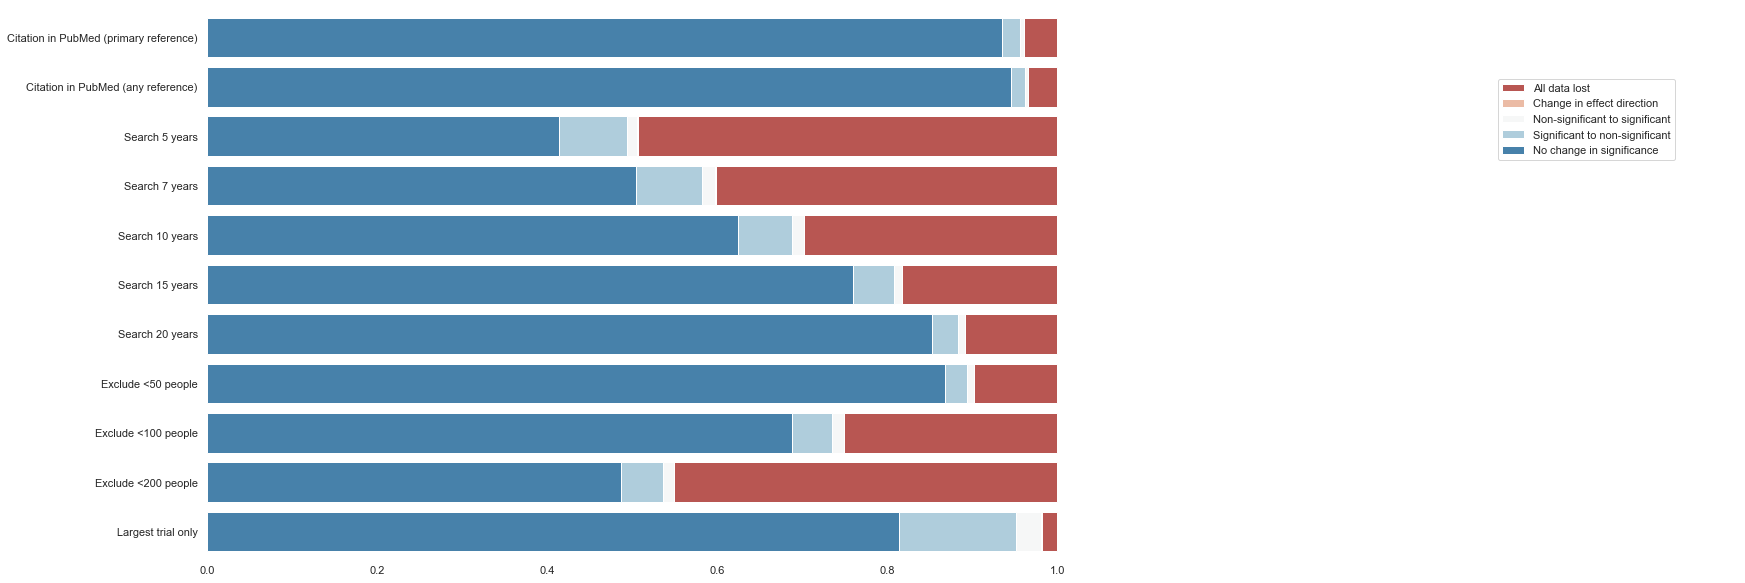

In [63]:
colnames=list(accum)[1:]
colnames.reverse()

sns.set_color_codes("bright")
sns.set_style("white")
sns.set_color_codes("bright")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 32

f, ax = plt.subplots(figsize=(16, 10))

pal= ['#969696', '#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']

for cn, color in zip(colnames,  sns.color_palette("RdBu", 5) ):
    sns.barplot(x=cn, y="Strategy", data=accum,
            label=cn, color=color)

ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True, right=True)

lgd = f.legend(bbox_to_anchor=(1.3, 0.7), loc=2, borderaxespad=0.)
f.savefig('out3/area_plot_sig.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [64]:
# generate data for stacked bars

table_out = []

for s, sim_title in zip(sim_codes, sim_titles):

    table_row = OrderedDict()
    
    # First add raw numbers includes/excludeds
    
    table_row['Strategy'] = sim_title
        
    accum_sum = 0.
    
    for change_cat in effect_change_cats:
        
                
        skip_groups = ["All events lost"]
        accum_sum += float(effect_results[s][change_cat])/float(total_ma) 
        if change_cat in skip_groups:
            continue
        
            
        if change_cat == "All studies lost":
            change_cat = "All data lost"
            
        if change_cat == "Large":
            change_cat = "Large change in effect estimate (≥30%)"
        
            
        if change_cat == "Moderate":
            change_cat = "Moderate change in effect estimate (≥20%)"

                        
        if change_cat == "Small":
            change_cat = "Small change in effect estimate (≥5%)"
        
        
        
        table_row[change_cat] = accum_sum
        
    table_out.append(table_row)


In [65]:
accum = pd.DataFrame(table_out)

In [66]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns
%matplotlib inline

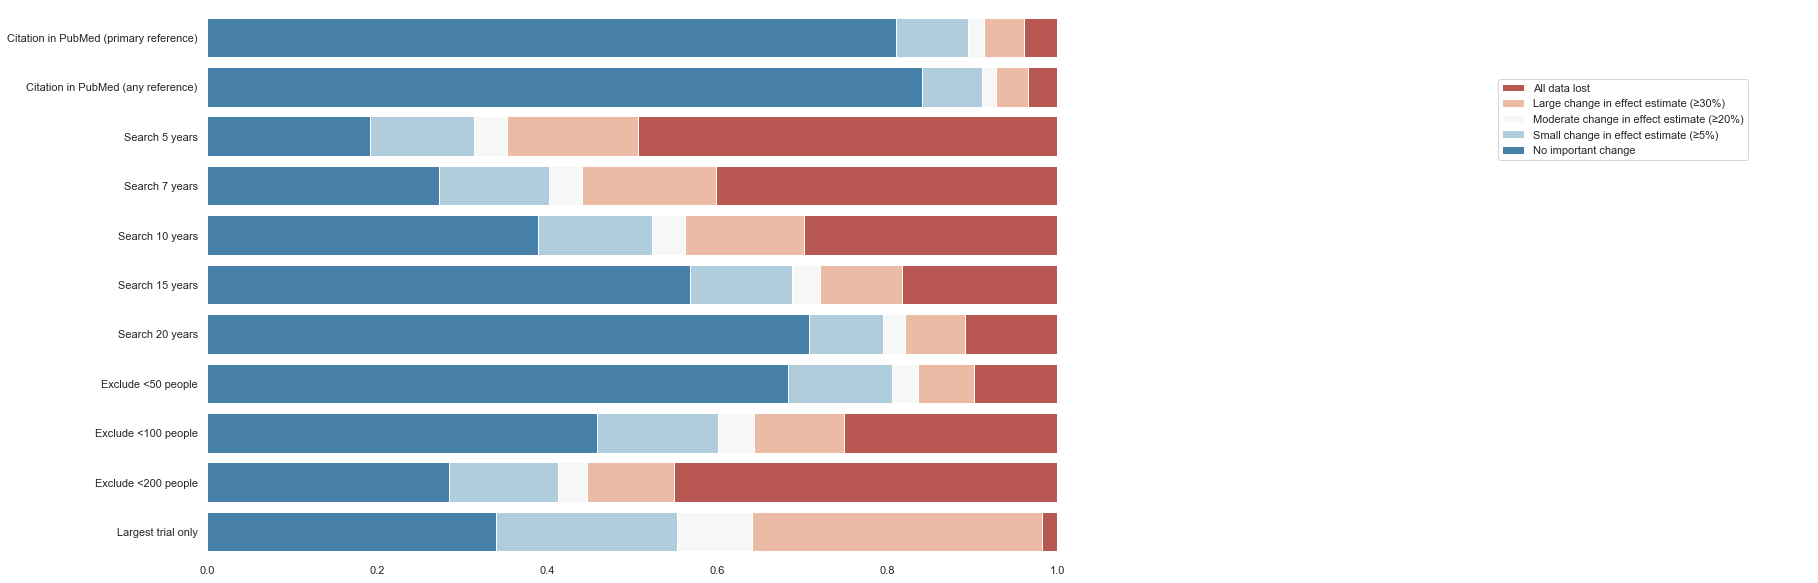

In [67]:
colnames=list(accum)[1:]
colnames.reverse()

sns.set_color_codes("bright")
sns.set_style("white")
sns.set_color_codes("bright")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 32

f, ax = plt.subplots(figsize=(16, 10))

pal= ['#969696', '#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']

for cn, color in zip(colnames, sns.color_palette("RdBu", 5) ):
    sns.barplot(x=cn, y="Strategy", data=accum,
            label=cn, color=color)

ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True, right=True)

lgd = f.legend(bbox_to_anchor=(1.3, 0.7), loc=2, borderaxespad=0.)
f.savefig('out3/effect_area_plot.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [72]:
from scipy.stats import sem

table_out = []

for s, sim_title in zip(sim_codes, sim_titles):
    table_row = OrderedDict()
    
    # First add raw numbers includes/excludeds
    
    table_row['Strategy'] = sim_title
    
    t = log_effect_sizes[s]

    table_row['Number of meta-analyses'] = len(t)
    
    # eligible meta-analyses are those with a usual care/placebo/inactive control
    # plus we also have removed any with no data (i.e. unable to calculate a change in effect size)
    
    upper = np.exp(t.mean() + 1.96*sem(t))
    lower = np.exp(t.mean() - 1.96*sem(t))
    point = np.exp(t.mean())
    table_row['relative OR, 95% CI'] = "{:.2f}, {:.2f}–{:.2f}".format(point, lower, upper)
    table_out.append(table_row)

In [69]:
table5 = pd.DataFrame(table_out)
table5.set_index('Strategy', inplace=True)
table5.to_csv('out3/Table_5.csv')

In [95]:
# version 2, display as percentage change with SD
from scipy.stats import sem

table_out = []

for s, sim_title in zip(sim_codes, sim_titles):
    table_row = OrderedDict()
    
    # First add raw numbers includes/excludeds
    
    table_row['Strategy'] = sim_title
    
    t = log_effect_sizes[s]
    
    # change abs change in log RORs into percentage changes
    def to_pc(log_ROR):
        return (np.exp(log_ROR)-1) * 100
    
#     t = (1.-np.exp(t)) * 100
    
    table_row['Number of meta-analyses'] = len(t)
    
    t = t[t!=0]
    # eligible meta-analyses are those with a usual care/placebo/inactive control
    # plus we also have removed any with no data (i.e. unable to calculate a change in effect size)
    
    upper = to_pc(t.mean() + 1.96*sem(t))
    lower = to_pc(t.mean() - 1.96*sem(t))
    sd = to_pc(np.std(t))
    point = to_pc(t.mean())
    table_row['% change (SD), 95% CI of mean'] = "{:+.1f} ({:.1f}), {:+.1f} to {:+.1f}".format(point, sd, lower, upper)
    table_out.append(table_row)

In [96]:

table5 = pd.DataFrame(table_out)
table5.set_index('Strategy', inplace=True)
table5.to_csv('out3/Table_5.csv')


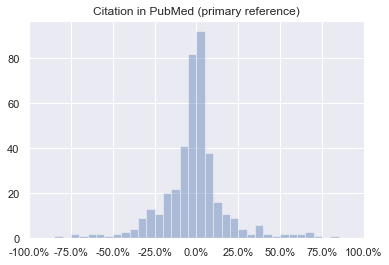

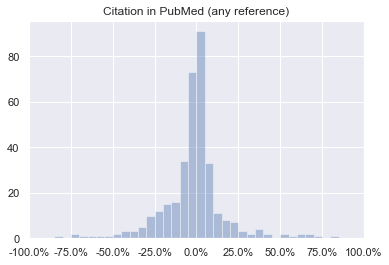

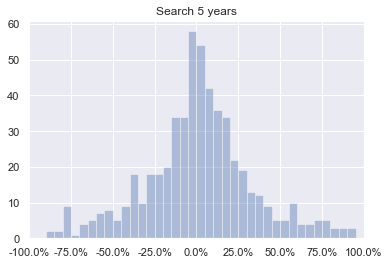

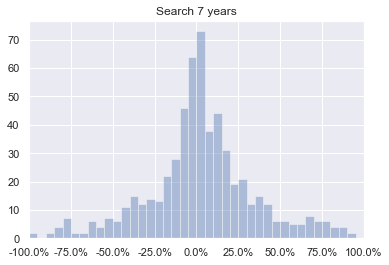

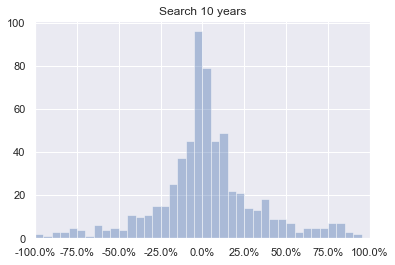

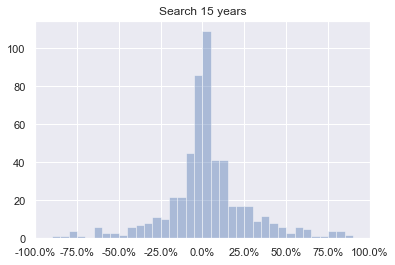

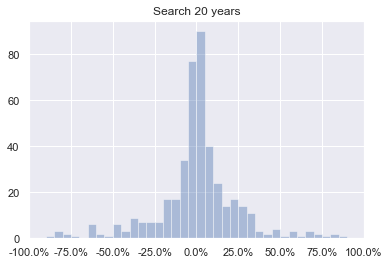

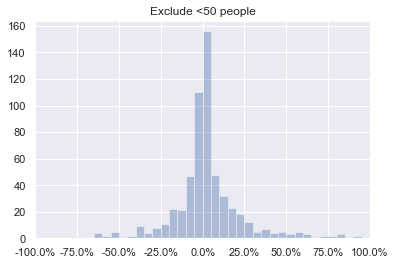

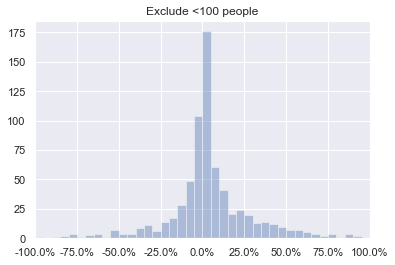

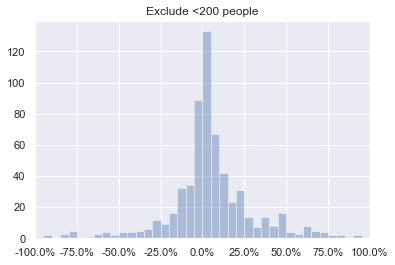

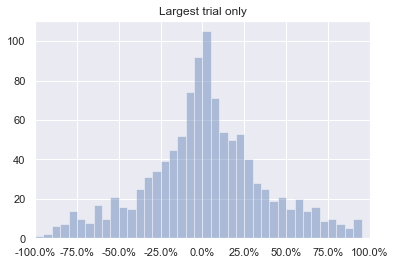

In [78]:
for s, sim_title in zip(sim_codes, sim_titles):
    
    sns.set(color_codes=True)

    changes = 100*(np.exp(log_effect_sizes[s])-1)
    plt.figure()
    p = sns.distplot((changes[changes!=0]), bins = np.arange(-100, 100, 5), kde=False)
    p.set_title(sim_title)
    
    
    p.set_xlim(-100,100)

    vals = p.get_xticks()

    p.set_xticklabels(['{}%'.format(x) for x in vals])

    p.get_figure().savefig('out3/distplot_{}.png'.format(s))
    

